In [1]:
from glob import glob
from os.path import join
import pandas as pd
import numpy as np
import pickle

In [20]:
from load_results_for_python_lib import \
    load_moment_df, add_metadata, VALID_METHODS, add_deviation_stats, add_derived_stats

In [12]:
base_folder = '../blade_runs/'

folder_method_list = (
    (join(base_folder, "nuts_results/"), 'NUTS'),
    (join(base_folder, "dadvi_results/"), 'DADVI'),
    (join(base_folder, "lrvb_results/"), 'LRVB'),
    (join(base_folder, "raabbvi_results/"), 'RAABBVI'),
    (join(base_folder, "sadvi_results/"), 'SADVI'),
    (join(base_folder, "sfullrank_advi_results/"), 'SADVI_FR'),
    (join(base_folder, 'lrvb_doubling_results'), 'LRVB_Doubling')
)

all_results = dict()

print('Loading data.\n')
for cur_folder, cur_method in folder_method_list:
    print(cur_method, cur_folder)
    data = load_moment_df(cur_folder)
    data = add_metadata(data, cur_method)
    all_results[cur_method] = data

Loading data.

NUTS ../blade_runs/nuts_results/
DADVI ../blade_runs/dadvi_results/


LRVB ../blade_runs/lrvb_results/
RAABBVI ../blade_runs/raabbvi_results/
SADVI ../blade_runs/sadvi_results/
SADVI_FR ../blade_runs/sfullrank_advi_results/
LRVB_Doubling ../blade_runs/lrvb_doubling_results


In [13]:
# Assert that VALID_METHODS and the loaded methods are the same
assert(len(set(all_results.keys()).symmetric_difference(VALID_METHODS)) == 0)

In [14]:
# Check which models are missing for which method.  If a model / method pair is missing we
# should know why!

method_models = {x: all_results[x]['model_name'].tolist() for x in VALID_METHODS}
all_models = set().union(*[ v for k, v in method_models.items() ])
all_missing_models = set([])

for method in VALID_METHODS:
    print(method)
    missing_models = all_models.difference(method_models[method])
    if len(missing_models) > 0:
        print('Missing models:')
        print('\n'.join(missing_models))
        all_missing_models = all_missing_models.union(missing_models)
    else:
        print('Nothing missing!')
    print('\n')

print('Missing for at least one method: ', all_missing_models)

NUTS
Nothing missing!


RAABBVI
Missing models:
tennis
potus


DADVI
Nothing missing!


LRVB
Missing models:
potus


SADVI
Missing models:
test


SADVI_FR
Missing models:
potus


LRVB_Doubling
Missing models:
potus


Missing for at least one method:  {'tennis', 'potus', 'test'}


In [15]:
# Remove models that are missing for at least one method, in order
# to avoid biasing results.
for method in VALID_METHODS:
    is_missing = all_results[method]['model_name'].apply(lambda x: x in all_missing_models)
    print(f'Removing {np.sum(is_missing)} from {method}')
    all_results[method] = all_results[method][np.logical_not(is_missing)]

Removing 3 from NUTS
Removing 1 from RAABBVI
Removing 3 from DADVI
Removing 2 from LRVB
Removing 2 from SADVI
Removing 2 from SADVI_FR
Removing 2 from LRVB_Doubling


In [18]:
raabbvi_maxiter = 19900

method_1 = 'LRVB_Doubling'
method_2 = 'RAABBVI'

#method_1_df = add_deviation_stats(all_results[method_1], all_results['NUTS']).dropna()
method_1_df = add_deviation_stats(all_results[method_1], all_results['NUTS'])

#method_2_df = add_deviation_stats(all_results[method_2], all_results['NUTS']).dropna()
method_2_df = add_deviation_stats(all_results[method_2], all_results['NUTS'])


/home/rgiordan/Documents/git_repos/DADVI/dadvi-experiments/comparison/analysis/load_results_for_python_lib.py:31: RuntimeWarning: invalid value encountered in divide
  return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x]
/home/rgiordan/Documents/git_repos/DADVI/dadvi-experiments/comparison/analysis/load_results_for_python_lib.py:35: RuntimeWarning: invalid value encountered in divide
  return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x]
/home/rgiordan/Documents/git_repos/DADVI/dadvi-experiments/comparison/analysis/load_results_for_python_lib.py:31: RuntimeWarning: invalid value encountered in divide
  return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x]
/home/rgiordan/Documents/git_repos/DADVI/dadvi-experiments/comparison/analysis/load_results_for_python_lib.py:35: RuntimeWarning: invalid value encountered in divide
  return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x]


In [21]:
method_1_df = add_derived_stats(method_1_df)
method_2_df = add_derived_stats(method_2_df)

In [22]:
print(method_1_df.keys())

Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime', 'mean_deviations', 'sd_deviations', 'var_names',
       'mean_deviations_flat', 'sd_deviations_flat', 'mean_rms', 'sd_rms'],
      dtype='object')


In [23]:
print(method_1_df['mean_deviations_flat'][1])
print(method_1_df['mean_deviations'][1])

[ 0.41833797 -0.10241049  0.52083841  0.03845086  0.30064341 -0.49431951]
{'Intercept': 0.4183379716251451, 'c_dist100': array([0.03845086]), 'c_arsenic': array([0.52083841]), 'c_dist100:c_arsenic': array([0.30064341]), 'assoc': array([-0.10241049]), 'educ4': array([-0.49431951])}


In [24]:
# Look at the data saved for each method.  Not all metadata is the same.
for method in VALID_METHODS:
    print(f'{method}: {all_results[method].keys()}')

NUTS: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'runtime_path',
       'runtime'],
      dtype='object')
RAABBVI: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime', 'converged'],
      dtype='object')
DADVI: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime'],
      dtype='object')
LRVB: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime'],
      dtype='object')
SADVI: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime', 'converged'],
      dtype='object')
SADVI_FR: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime', 'converged'],
      dtype='object')
LRVB_Doubling: Index(['draw_dict_path', 'means', 'sds', 'model_name', 'info_path', 'metadata',
       'runtime'],
      dtype='object')


In [25]:
# Look at the proportion of modles that converged for each method
for method in VALID_METHODS:
    prop_converged = all_results[method].get('converged', None)
    if prop_converged is not None:
        print(f'Proportion converged for {method:10}: {prop_converged.mean()}')

Proportion converged for RAABBVI   : 0.71875
Proportion converged for SADVI     : 0.25
Proportion converged for SADVI_FR  : 0.0


In [26]:
comparison = method_1_df.merge(
    method_2_df, on='model_name',
    suffixes=(f'_{method_1}', f'_{method_2}'))

comparison

,draw_dict_path_LRVB_Doubling,means_LRVB_Doubling,sds_LRVB_Doubling,model_name,info_path_LRVB_Doubling,metadata_LRVB_Doubling,runtime_LRVB_Doubling,mean_deviations_LRVB_Doubling,sd_deviations_LRVB_Doubling,var_names_LRVB_Doubling,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 97.86866517275877, 'treatment': ...","{'Intercept': 0.8005068503524355, 'treatment':...",electric_multi_preds,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.784979...,1.366690,"{'Intercept': 1.256952838887766, 'treatment': ...","{'Intercept': 0.3858668025716703, 'treatment':...","[Intercept, post_test_sigma, pre_test, treatment]",...,"{'opt_result': [97.14944286659525, 2.088423740...",26.767233,True,"{'Intercept': 0.030284437861469574, 'treatment...","{'Intercept': 0.05395200876812756, 'treatment'...","[Intercept, post_test_sigma, pre_test, treatment]","[0.030284437861469574, -0.07592310238241431, 0...","[0.05395200876812756, -0.024309508446959876, -...",0.063506,0.036033
1,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3586016277938707, 'c_dist100':...","{'Intercept': 0.04137687220630652, 'c_dist100'...",wells_daae_c,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.358519...,1.489030,"{'Intercept': 0.4183379716251451, 'c_dist100':...","{'Intercept': 0.05418356736819176, 'c_dist100'...","[Intercept, assoc, c_arsenic, c_dist100, c_dis...",...,"{'opt_result': [0.3414762179027639, -0.1233801...",49.201283,True,"{'Intercept': -0.016740693328142767, 'c_dist10...","{'Intercept': -0.007262592664979927, 'c_dist10...","[Intercept, assoc, c_arsenic, c_dist100, c_dis...","[-0.016740693328142767, -0.047622245031883115,...","[-0.007262592664979927, 0.0016459971943869657,...",0.046637,0.040670
2,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': -0.9352684764451462, 'x': [15.28...","{'Intercept': 0.3957907800065732, 'x': [0.5013...",test_rstanarm,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-4.317471...,3.441839,"{'Intercept': -0.008322796211586637, 'x': [0.0...","{'Intercept': -0.23243771211642478, 'x': [0.01...","[1|z1, 1|z1_offset, 1|z1_sigma, 1|z1_z2, 1|z1_...",...,"{'opt_result': [0.9702323592819407, -0.1426156...",51.647736,False,"{'Intercept': 0.3590092451963155, 'x': [-24.51...","{'Intercept': -0.9903779551190522, 'x': [-0.99...","[1|z1, 1|z1_offset, 1|z1_sigma, 1|z1_z2, 1|z1_...","[-0.6374435358965209, 0.17515082502624535, 1.4...","[-0.9798776565016813, -0.9818607689517708, -0....",9.381088,0.963614
3,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 97.07068567951451, 'treatment': ...","{'Intercept': 0.6986516382234854, 'treatment':...",electric_1b,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-2.175397...,3.109489,"{'Intercept': -0.1419505629271985, 'treatment'...","{'Intercept': -0.047145846100654074, 'treatmen...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...",...,"{'opt_result': [0.9999703086376698, 1.15956376...",40.200612,False,"{'Intercept': -92.94557840902398, 'treatment':...","{'Intercept': -0.5219018308426985, 'treatment'...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...","[22.80498593544026, 24.587830213032607, 25.267...","[-0.023174231569471352, 0.0242468334535985, -0...",16.751252,0.636931
4,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 9.745179818118217, 'height': [0....","{'Intercept': 0.03476694783640978, 'height': [...",earnings2,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.74436 ...,1.265019,"{'Intercept': 1.2012992818194665, 'height': [0...","{'Intercept': 0.34184817251472227, 'height': [...","[Intercept, height, np.log(earnings)_sigma, sex]

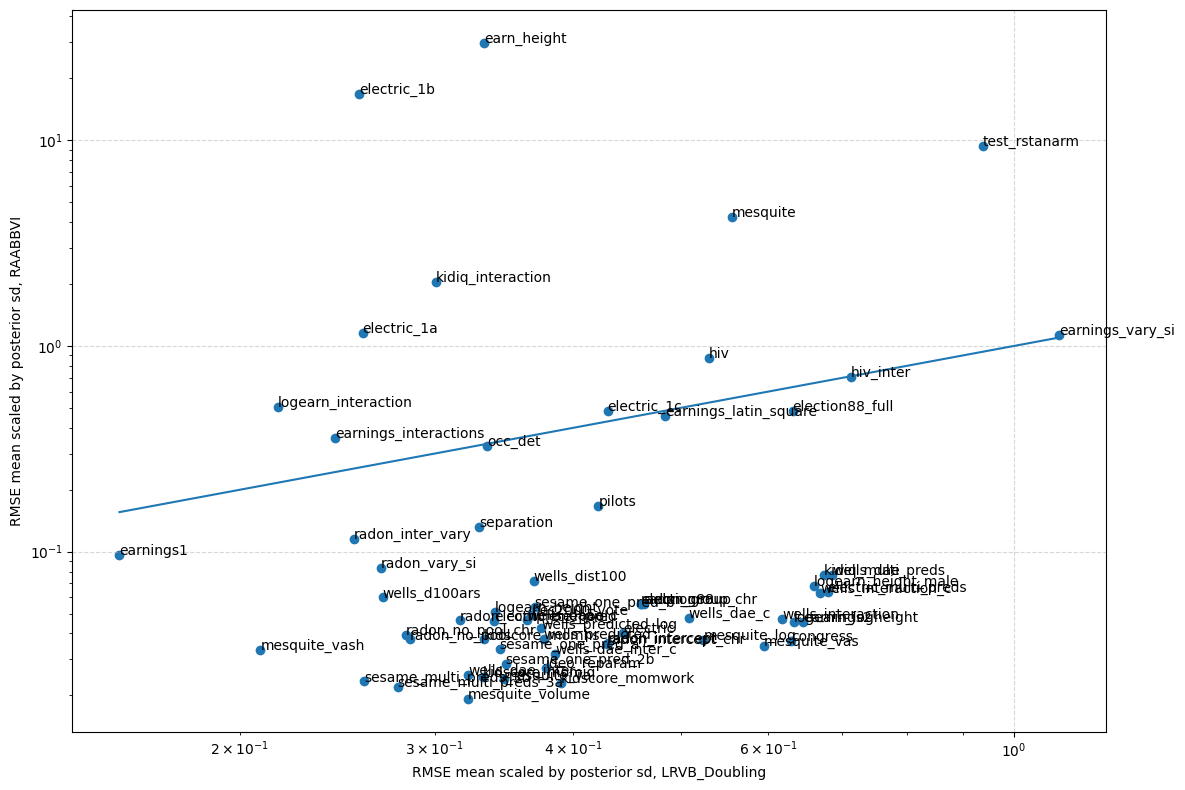

In [27]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'mean_rms_{method_1}'].min(), comparison[f'mean_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'mean_rms_{method_1}'], comparison[f'mean_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'mean_rms_{method_1}'), getattr(row, f'mean_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE mean scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE mean scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./mean_comparison.png', dpi=300)


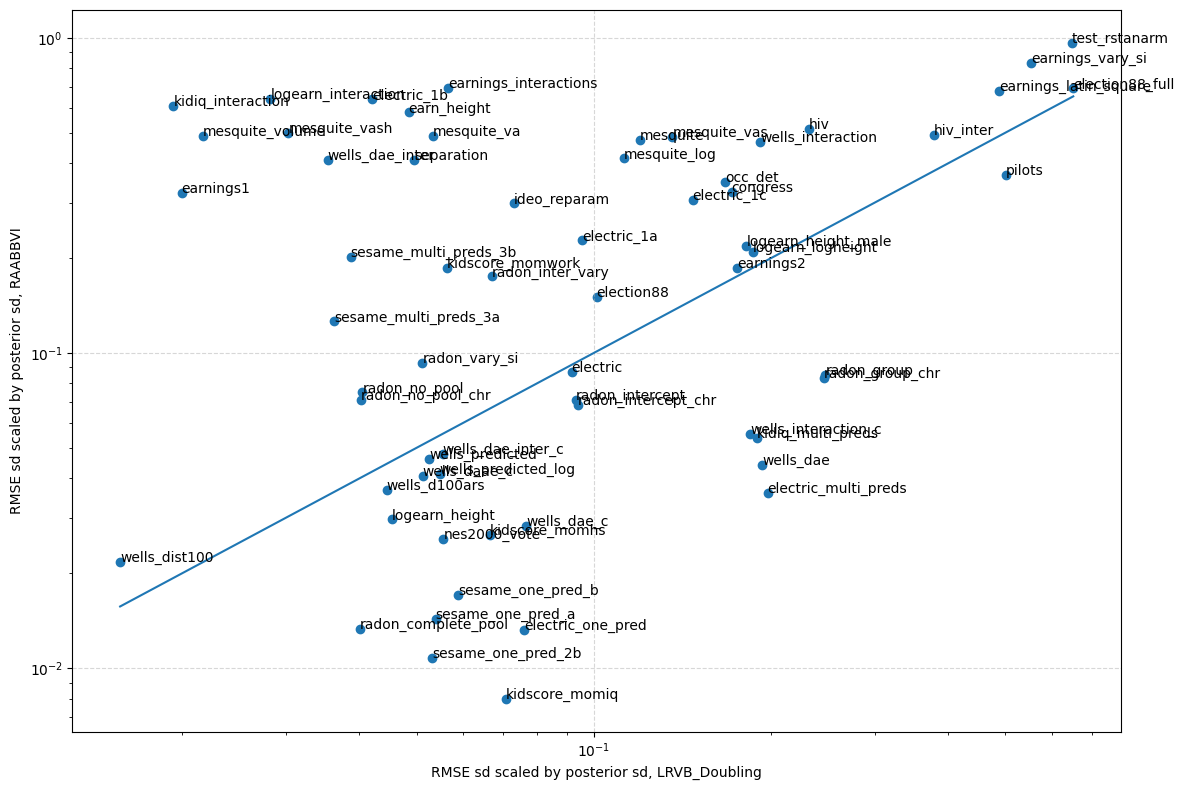

In [28]:
f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'sd_rms_{method_1}'].min(), comparison[f'sd_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'sd_rms_{method_1}'], comparison[f'sd_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'sd_rms_{method_1}'), getattr(row, f'sd_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE sd scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE sd scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./sd_comparison.png', dpi=300)

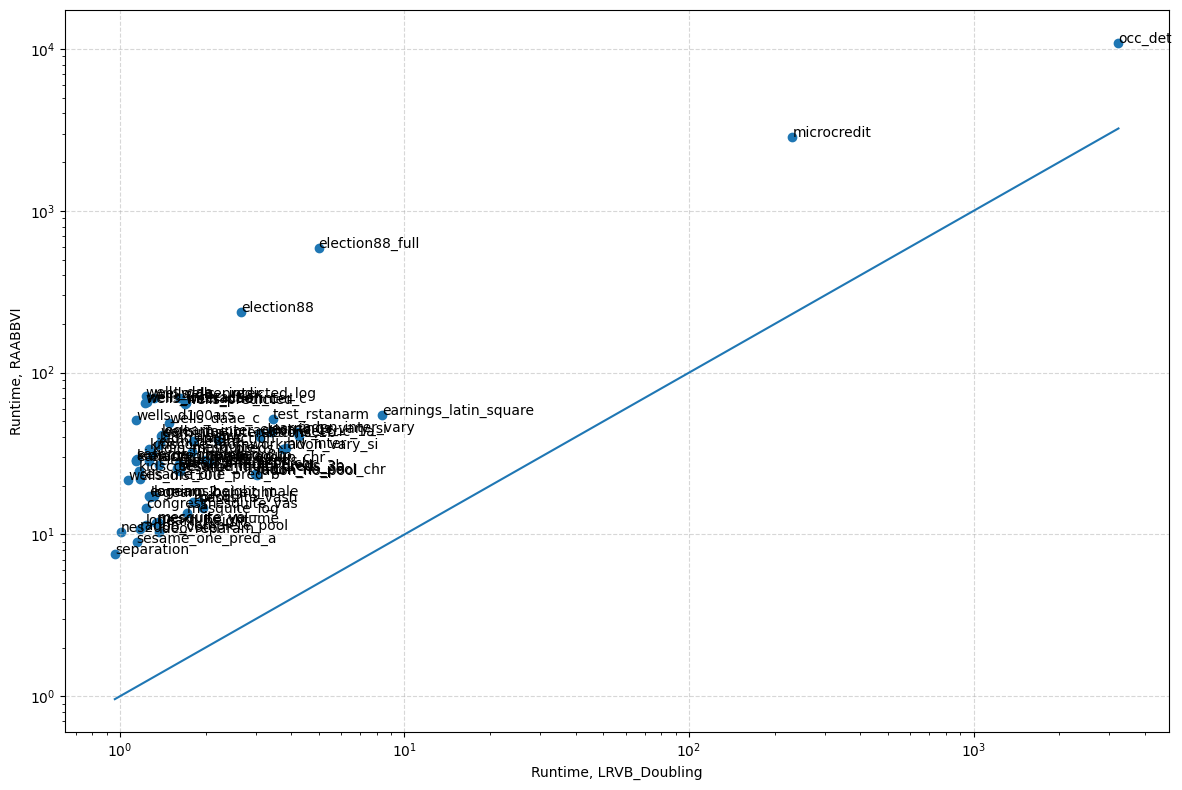

In [29]:

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'runtime_{method_1}'].min(), comparison[f'runtime_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'runtime_{method_1}'], comparison[f'runtime_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'runtime_{method_1}'), getattr(row, f'runtime_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'Runtime, {method_1}')
ax.set_ylabel(f'Runtime, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('runtime_comparison.png', dpi=300)

In [30]:
comparison.head()

,draw_dict_path_LRVB_Doubling,means_LRVB_Doubling,sds_LRVB_Doubling,model_name,info_path_LRVB_Doubling,metadata_LRVB_Doubling,runtime_LRVB_Doubling,mean_deviations_LRVB_Doubling,sd_deviations_LRVB_Doubling,var_names_LRVB_Doubling,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 97.86866517275877, 'treatment': ...","{'Intercept': 0.8005068503524355, 'treatment':...",electric_multi_preds,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.784979...,1.366690,"{'Intercept': 1.256952838887766, 'treatment': ...","{'Intercept': 0.3858668025716703, 'treatment':...","[Intercept, post_test_sigma, pre_test, treatment]",...,"{'opt_result': [97.14944286659525, 2.088423740...",26.767233,True,"{'Intercept': 0.030284437861469574, 'treatment...","{'Intercept': 0.05395200876812756, 'treatment'...","[Intercept, post_test_sigma, pre_test, treatment]","[0.030284437861469574, -0.07592310238241431, 0...","[0.05395200876812756, -0.024309508446959876, -...",0.063506,0.036033
1,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3586016277938707, 'c_dist100':...","{'Intercept': 0.04137687220630652, 'c_dist100'...",wells_daae_c,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.358519...,1.489030,"{'Intercept': 0.4183379716251451, 'c_dist100':...","{'Intercept': 0.05418356736819176, 'c_dist100'...","[Intercept, assoc, c_arsenic, c_dist100, c_dis...",...,"{'opt_result': [0.3414762179027639, -0.1233801...",49.201283,True,"{'Intercept': -0.016740693328142767, 'c_dist10...","{'Intercept': -0.007262592664979927, 'c_dist10...","[Intercept, assoc, c_arsenic, c_dist100, c_dis...","[-0.016740693328142767, -0.047622245031883115,...","[-0.007262592664979927, 0.0016459971943869657,...",0.046637,0.040670
2,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': -0.9352684764451462, 'x': [15.28...","{'Intercept': 0.3957907800065732, 'x': [0.5013...",test_rstanarm,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-4.317471...,3.441839,"{'Intercept': -0.008322796211586637, 'x': [0.0...","{'Intercept': -0.23243771211642478, 'x': [0.01...","[1|z1, 1|z1_offset, 1|z1_sigma, 1|z1_z2, 1|z1_...",...,"{'opt_result': [0.9702323592819407, -0.1426156...",51.647736,False,"{'Intercept': 0.3590092451963155, 'x': [-24.51...","{'Intercept': -0.9903779551190522, 'x': [-0.99...","[1|z1, 1|z1_offset, 1|z1_sigma, 1|z1_z2, 1|z1_...","[-0.6374435358965209, 0.17515082502624535, 1.4...","[-0.9798776565016813, -0.9818607689517708, -0....",9.381088,0.963614
3,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 97.07068567951451, 'treatment': ...","{'Intercept': 0.6986516382234854, 'treatment':...",electric_1b,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-2.175397...,3.109489,"{'Intercept': -0.1419505629271985, 'treatment'...","{'Intercept': -0.047145846100654074, 'treatmen...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...",...,"{'opt_result': [0.9999703086376698, 1.15956376...",40.200612,False,"{'Intercept': -92.94557840902398, 'treatment':...","{'Intercept': -0.5219018308426985, 'treatment'...","[1|pair, 1|pair_offset, 1|pair_sigma, Intercep...","[22.80498593544026, 24.587830213032607, 25.267...","[-0.023174231569471352, 0.0242468334535985, -0...",16.751252,0.636931
4,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 9.745179818118217, 'height': [0....","{'Intercept': 0.03476694783640978, 'height': [...",earnings2,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.74436 ...,1.265019,"{'Intercept': 1.2012992818194665, 'height': [0...","{'Intercept': 0.34184817251472227, 'height': [...","[Intercept, height, np.log(earnings)_sigma, sex]

In [31]:
all_results['LRVB_Doubling']['M'] = all_results['LRVB_Doubling']['metadata'].apply(lambda x: x['M'])

/tmp/ipykernel_30215/592608418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results['LRVB_Doubling']['M'] = all_results['LRVB_Doubling']['metadata'].apply(lambda x: x['M'])


In [32]:
all_results['LRVB_Doubling'][['model_name', 'runtime', 'M']].sort_values('M', ascending=False).head(20)

,model_name,runtime,M
32,occ_det,3231.954773,32
33,radon_no_pool,3.024529,16
13,hiv_inter,3.847775,16
39,electric_1a,4.250730,16
25,earnings_latin_square,8.337828,16
24,radon_no_pool_chr,2.992355,16
47,radon_vary_si,3.738899,16
22,microcredit,230.966649,16
35,radon_inter_vary,4.206867,16
3,electric_1b,3.109489,16


In [33]:
all_results['LRVB'][['model_name', 'runtime']].sort_values('runtime')

,model_name,runtime
52,separation,0.768533
40,nes2000_vote,0.794957
34,wells_dist100,0.881234
7,wells_d100ars,0.914805
59,earnings1,0.994757
...,...,...
25,earnings_latin_square,3.982372
2,test_rstanarm,4.029059
56,election88_full,6.587784
22,microcredit,253.021683
